In [1]:
import torch
import torch.utils.data as data
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
# Hyperparameters
classes = ["lung_aca", "lung_n", "lung_scc"]
batch_size = 30
n = 768//2 # image resize values

In [6]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((n, n)),
    transforms.ToTensor()
])

# Datasets
dataset = datasets.ImageFolder(root='../dataset', transform=transform)

# Splits
train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = val_size

trainset, remdata = data.random_split(dataset, [train_size, val_size*2])
validset, testset = data.random_split(remdata, [val_size, test_size])

# DataLoaders
trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = data.DataLoader(validset, batch_size=batch_size, shuffle=True)
testloader = data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [8]:
# Split sizes
len(trainset), len(validset), len(testset)

(10500, 2250, 2250)

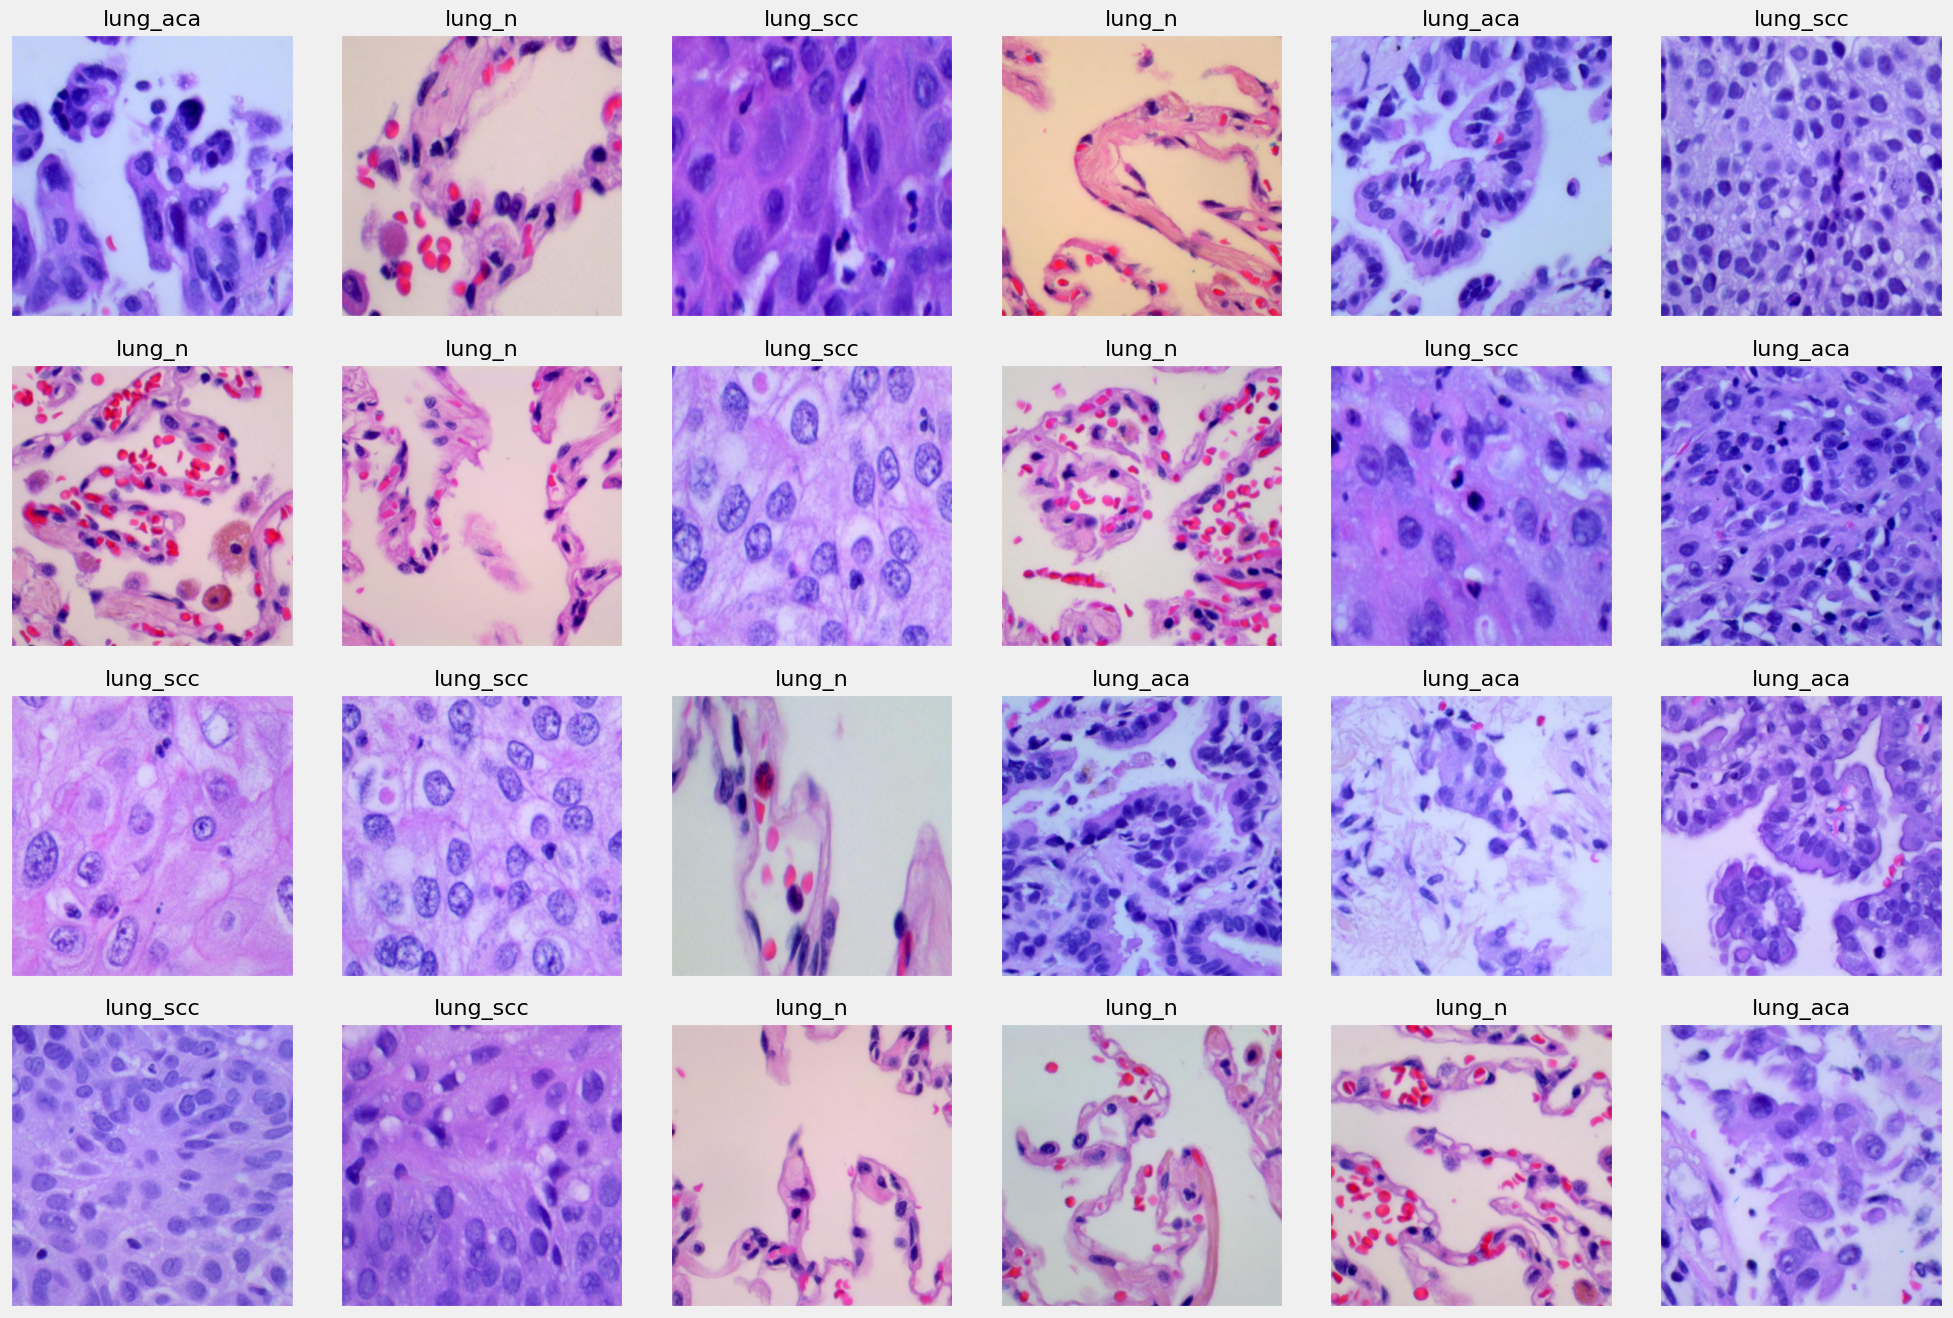

In [23]:
# Visualizations
images, labels = next(iter(trainloader))

fig = plt.figure(figsize=(20, 20))
plt.style.use("fivethirtyeight")
x, y = 6, 6
for i in range(24):
    ax = plt.subplot(y, x, i+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(f"{classes[labels[i]]}", fontsize=16)
plt.tight_layout()
plt.show()

- N are lighter in color with red/pink patches making them rather easy to identify with naked eye.
- There are some similar patches to SCC and ACA, although not so prevalent

In [11]:
# plot data distribution

In [12]:
# CNN network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 48 * 48, 2048)
        self.fc2 = nn.Linear(2048, 64)
        self.fc3 = nn.Linear(64, len(classes))
        # dropout
        # self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening
        # print(x.shape)
        x = x.view(-1, 64 * 48 * 48)
        # fully connected layers
        # x = self.dropout(F.relu(self.fc1(x)))
        # x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=147456, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [13]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [14]:
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=.01)

In [17]:
# number of epochs to train the model
n_epochs = 5 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    correct_train = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(data)
        # calculate the batch loss
        loss = criterion(outputs, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == target).sum().item()
        
    ######################    
    # validate the model #
    ######################
    valid_loss = 0.0
    correct_valid = 0.0
    model.eval()
    for data, target in validloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(data)
        # calculate the batch loss
        loss = criterion(outputs, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # accuracy
        _, predicted = torch.max(outputs, 1)
        correct_valid += (predicted == target).sum().item()
    
    # calculate average losses and accuracies
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)
    train_accuracy = correct_train/len(trainloader.dataset)
    valid_accuracy = correct_valid/len(validloader.dataset)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            epoch, train_loss, train_accuracy, valid_loss, valid_accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 2 	Training Loss: 1.004267 	Training Accuracy: 0.488381 	Validation Loss: 0.770153 	Validation Accuracy: 0.591556
Validation loss decreased (inf --> 0.770153).  Saving model ...
Epoch: 3 	Training Loss: 0.536611 	Training Accuracy: 0.733429 	Validation Loss: 0.527467 	Validation Accuracy: 0.730222
Validation loss decreased (0.770153 --> 0.527467).  Saving model ...
Epoch: 4 	Training Loss: 0.428902 	Training Accuracy: 0.808857 	Validation Loss: 0.449248 	Validation Accuracy: 0.798222
Validation loss decreased (0.527467 --> 0.449248).  Saving model ...
Epoch: 5 	Training Loss: 0.384328 	Training Accuracy: 0.835810 	Validation Loss: 0.322146 	Validation Accuracy: 0.868889
Validation loss decreased (0.449248 --> 0.322146).  Saving model ...
Epoch: 6 	Training Loss: 0.343158 	Training Accuracy: 0.862667 	Validation Loss: 0.314968 	Validation Accuracy: 0.867111
Validation loss decreased (0.322146 --> 0.314968).  Saving model ...


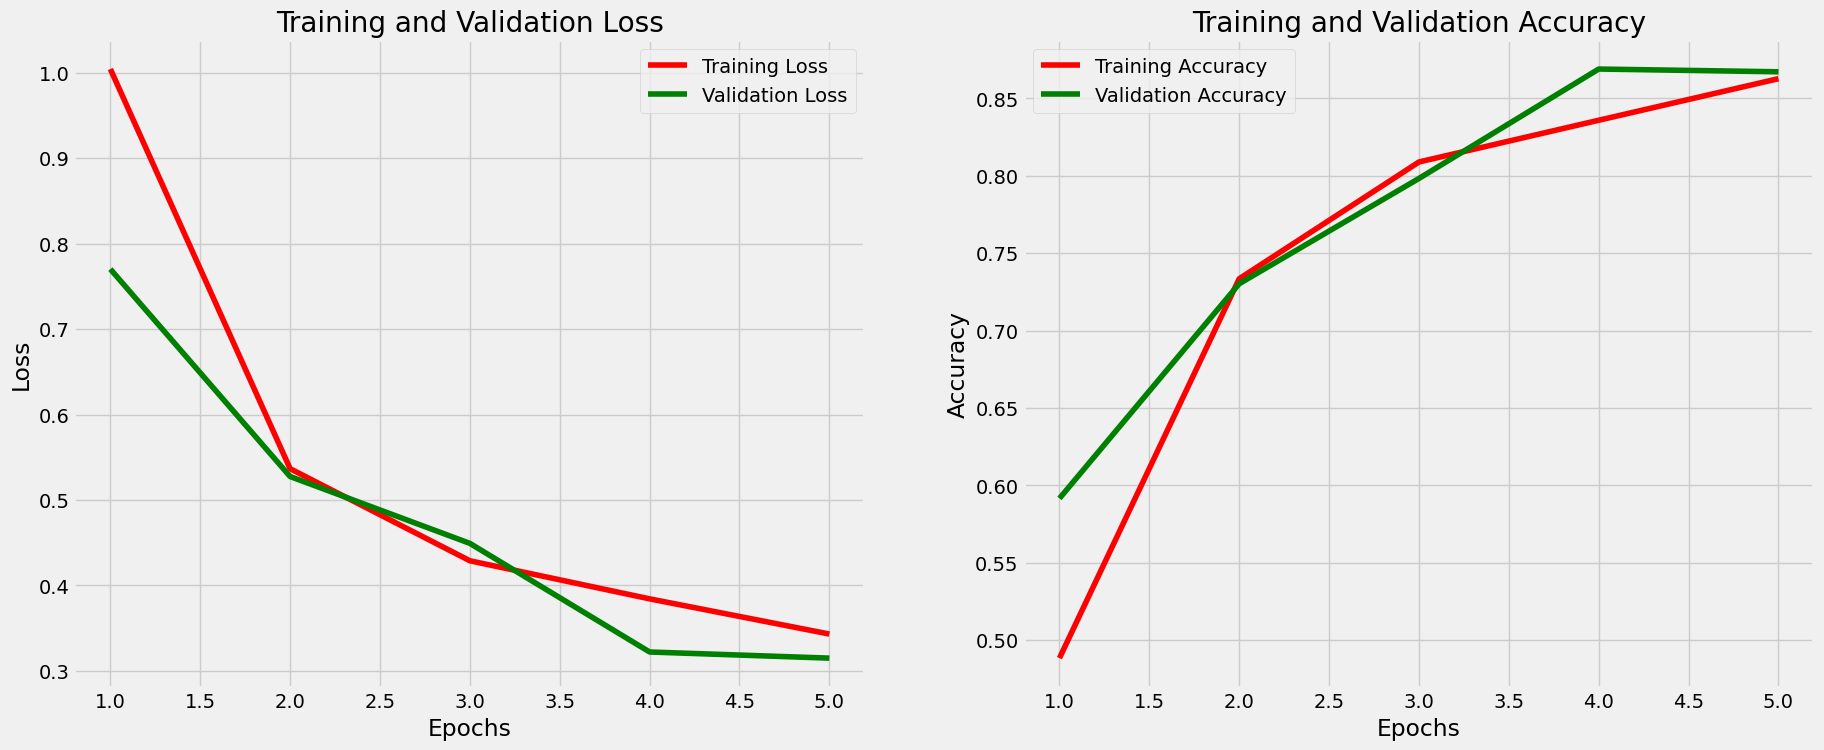

In [24]:
# performance overtime
def model_performance(train_accuracies, train_losses, validation_accuracies, validation_losses, epochs):
    # plot training history
    plt.figure(figsize=(20,8))
    plt.style.use("fivethirtyeight")

    epochs = [i+1 for i in range(epochs)]

    # losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label="Training Loss")
    plt.plot(epochs, validation_losses, 'g', label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label="Training Accuracy")
    plt.plot(epochs, validation_accuracies, 'g', label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout
    plt.show()

model_performance(train_accuracies, train_losses, valid_accuracies, valid_losses, n_epochs)

In [6]:
# Load trained model
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [26]:
# testing
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(3):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.290303

Test Accuracy of lung_aca: 75% (563/746)
Test Accuracy of lung_n: 94% (720/759)
Test Accuracy of lung_scc: 93% (700/745)

Test Accuracy (Overall): 88% (1983/2250)
